## Libs

In [1]:
import pandas as pd
import numpy as np 
import joblib
import sys
import matplotlib.pyplot as plt

from fast_ml.model_development import train_valid_test_split

from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, recall_score, precision_score, confusion_matrix as cm



from yellowbrick.classifier import confusion_matrix
from yellowbrick.classifier import ROCAUC
from yellowbrick.model_selection import FeatureImportances

## Extraction

In [2]:
# path to read specific csv data
path = r'C:\Users\erico\Documents\projeto classificacao\Telco-Customer-Churn\data\WA_Fn-UseC_-Telco-Customer-Churn.csv'
# config path scripts
sys.path.insert(0, r'C:\Users\erico\Documents\projeto classificacao\Telco-Customer-Churn\scripts')

from extract_data import read_data

df = read_data(path)
df_copy = df.set_index(['customerID']).copy()
df_copy.drop(['gender','PhoneService'], inplace=True, axis=1)

In [3]:
df_copy.head()

,SeniorCitizen,Partner,Dependents,tenure,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,,,,,,,,,,,,
7590-VHVEG,No,Yes,No,1,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
5575-GNVDE,No,No,No,34,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
3668-QPYBK,No,No,No,2,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
7795-CFOCW,No,No,No,45,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
9237-HQITU,No,No,No,2,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## train, valid, test split

In [4]:
X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(df_copy, target = 'Churn', train_size=0.8, valid_size=0.1, test_size=0.1)

print('X_train shape: ',X_train.shape)
print('y_train shape: ',y_train.shape)
print('X_valid shape: ',X_valid.shape)
print('y_valid shape: ',y_valid.shape)
print('X_test shape: ',X_test.shape)
print('y_test shape: ',y_test.shape)

X_train shape:  (5634, 17)
y_train shape:  (5634,)
X_valid shape:  (704, 17)
y_valid shape:  (704,)
X_test shape:  (705, 17)
y_test shape:  (705,)


## Feature Selection

In [5]:
num_cols = df_copy.select_dtypes(include=['number']).columns.tolist()

In [6]:
num_cols

['tenure', 'MonthlyCharges', 'TotalCharges']

In [7]:
cat_cols = df_copy.select_dtypes(include=['object']).columns.tolist()[:-1]

In [8]:
cat_cols

['SeniorCitizen',
 'Partner',
 'Dependents',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']

## Create Pipeline 

In [9]:
preprocessor = ColumnTransformer(
                                transformers=[
                                ('cat', OneHotEncoder(), cat_cols), 
                                ('num', MinMaxScaler(), num_cols)
                                ], remainder="passthrough")

model = LogisticRegression(C=0.1,
                           random_state=42,
                           max_iter=300, 
                           class_weight="balanced")

model_pipe = Pipeline(steps = [('preprocessor',preprocessor),
                                ('model', model)])

In [10]:
model_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat', OneHotEncoder(),
                                                  ['SeniorCitizen', 'Partner',
                                                   'Dependents',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod']),
                                                 ('num', MinMaxScaler(),
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges'])])),
                ('model',
                 LogisticRegression(C=0.1, class_weight='balanced',
                                    max_iter=300, random_state=42))])

## Training and Validate

In [11]:
# Encoder Target variables
le_Y = LabelEncoder()
y_train = le_Y.fit_transform(y_train)
y_valid = le_Y.transform(y_valid)
y_test = le_Y.transform(y_test)

In [12]:
# Treina o modelo
model_pipe.fit(X_train, y_train)      
# Faz predições
y_pred = model_pipe.predict(X_valid)
# Validação cruzada estratificada
skfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)  
recall = cross_val_score(model_pipe, X_valid, y_valid, scoring="recall", cv=skfold, n_jobs=-1)
# métrica auc
auc = roc_auc_score(y_valid, y_pred)
#Exibe as métricas 
print(f"Recall_CV:{recall.mean():.3f} STD: {recall.std():.2f}, AUC: {auc:.3f}",end="\n")
print(classification_report(y_valid, y_pred))

Recall_CV:0.791 STD: 0.09, AUC: 0.746
              precision    recall  f1-score   support

           0       0.89      0.72      0.80       509
           1       0.51      0.77      0.62       195

    accuracy                           0.73       704
   macro avg       0.70      0.75      0.71       704
weighted avg       0.79      0.73      0.75       704



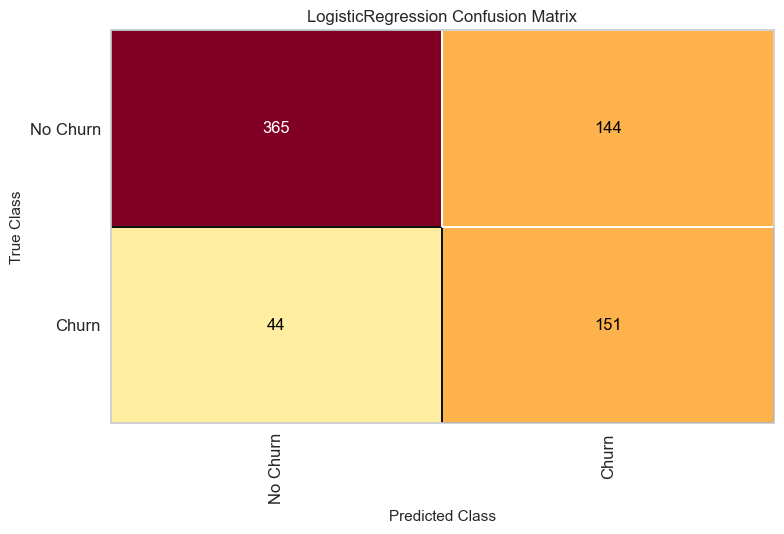

<Figure size 800x550 with 0 Axes>

In [13]:
# Exibe matriz de confusão
mapping = {0:"No Churn",1:"Churn"}
confusion_matrix(
    model_pipe,
    X_train, y_train, X_valid, y_valid,
    classes=['No Churn', 'Churn'],
    label_encoder=mapping
)
plt.tight_layout()

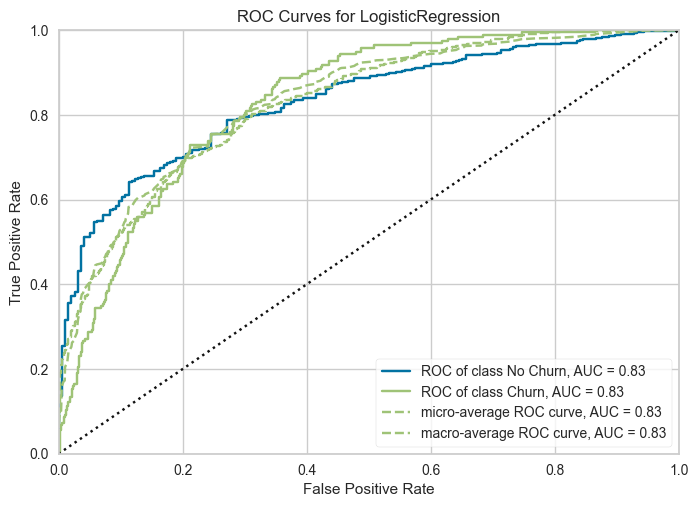

In [14]:
# # Exibe curva ROC
visualizer = ROCAUC(model_pipe, classes=["No Churn", "Churn"])
visualizer.fit(X_train, y_train)        
visualizer.score(X_valid, y_valid)        
visualizer.show();

## Optimization
- GridSearchCV

In [15]:
param_grid = {'model__C': [0.1, 1, 10],
              'model__penalty': ['l1', 'l2'],
              'model__solver': ['liblinear', 'saga']}

grid_search = GridSearchCV(model_pipe, param_grid, cv=5, scoring='recall')

grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)

{'model__C': 1, 'model__penalty': 'l1', 'model__solver': 'liblinear'}
0.8057214841960605


In [16]:
model = LogisticRegression(C=10,
                           penalty = 'l1',
                           solver = 'liblinear',
                           random_state=42,
                           max_iter=300, 
                           class_weight="balanced")

model_pipe = Pipeline(steps = [('preprocessor',preprocessor),
                                ('model', model)])

In [17]:
model_pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat', OneHotEncoder(),
                                                  ['SeniorCitizen', 'Partner',
                                                   'Dependents',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod']),
                                                 ('num', MinMaxScaler(),
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharges'])])),
                ('model',
                 LogisticRegression(C=10, class_weight='balanced', max_iter=300,
                                    penalty='l1', random_state=42,
                                    solver='liblinear'))])

In [18]:
# Treina o modelo
model_pipe.fit(X_train, y_train)      
# Faz predições
y_pred = model_pipe.predict(X_valid)
# Validação cruzada estratificada
skfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)  
recall = cross_val_score(model_pipe, X_valid, y_valid, scoring="recall", cv=skfold, n_jobs=-1)
# métrica auc
auc = roc_auc_score(y_valid, y_pred)
#Exibe as métricas 
print(f"Recall_CV:{recall.mean():.3f} STD: {recall.std():.2f}, AUC: {auc:.3f}",end="\n")
print(classification_report(y_valid, y_pred))

Recall_CV:0.785 STD: 0.06, AUC: 0.753
              precision    recall  f1-score   support

           0       0.90      0.72      0.80       509
           1       0.52      0.78      0.62       195

    accuracy                           0.74       704
   macro avg       0.71      0.75      0.71       704
weighted avg       0.79      0.74      0.75       704



## Test

AUC: 0.783
              precision    recall  f1-score   support

           0       0.91      0.75      0.82       508
           1       0.56      0.82      0.66       197

    accuracy                           0.77       705
   macro avg       0.74      0.78      0.74       705
weighted avg       0.81      0.77      0.78       705



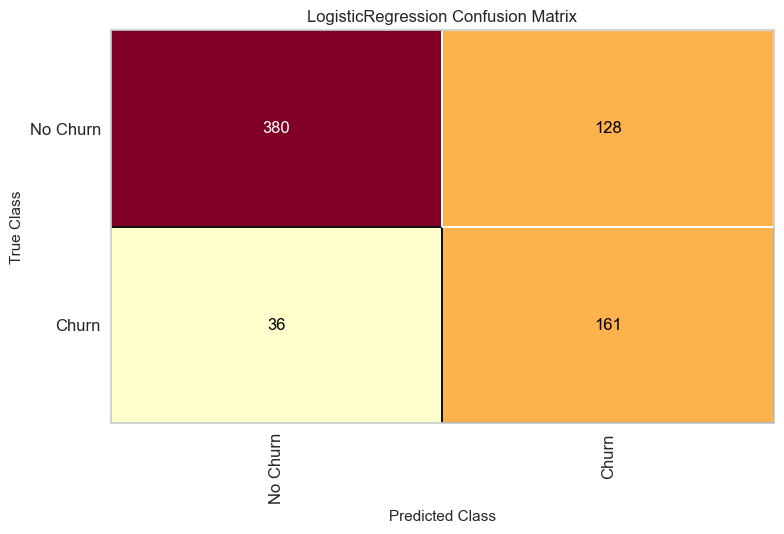

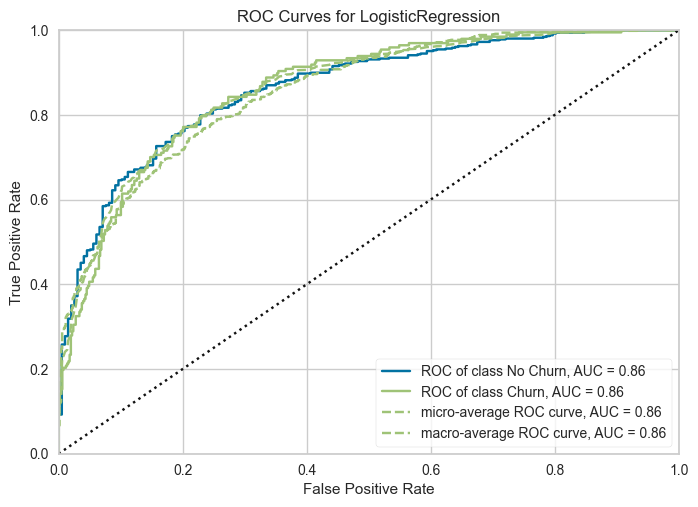

In [19]:
# Treina o modelo
model_pipe.fit(X_train, y_train)
# Faz predições
y_pred = model_pipe.predict(X_test)
# métrica área sob a curva de característica de operação do receptor
auc = roc_auc_score(y_test, y_pred)
#Exibe as métricas 
print(f"AUC: {auc:.3f}",end="\n")
print(classification_report(y_test, y_pred))

# Exibe matriz de confusão
mapping = {0:"No Churn",1:"Churn"}
confusion_matrix(
    model_pipe,
    X_train, y_train, X_test, y_test,
    classes=['No Churn', 'Churn'],
    label_encoder=mapping
)
plt.tight_layout()

# Exibe curva ROC
visualizer = ROCAUC(model_pipe, classes=["No Churn", "Churn"])
visualizer.fit(X_train, y_train)        
visualizer.score(X_test, y_test)        
visualizer.show();

## Feature Importance

In [20]:
# ajustar o preprocessor no conjunto de treinamento X_train
X_train_transformed = preprocessor.fit_transform(X_train)

# ajustar o modelo logístico no conjunto de treinamento transformado
logistic_reg = LogisticRegression(C=10,
                                  penalty = 'l1',
                                  solver = 'liblinear',
                                  random_state=42,
                                  max_iter=300, 
                                  class_weight="balanced")
                                  
logistic_reg.fit(X_train_transformed, y_train)

# transformar o conjunto de testes X_test
X_test_transformed = preprocessor.transform(X_test)

# obter o nome das características do ColumnTransformer
cat_encoder = preprocessor.named_transformers_['cat']
cat_cols_transformed = cat_encoder.transform(X_train[cat_cols])
cat_encoder_cols = cat_encoder.get_feature_names(cat_cols)
feature_names = cat_encoder_cols.tolist() + num_cols

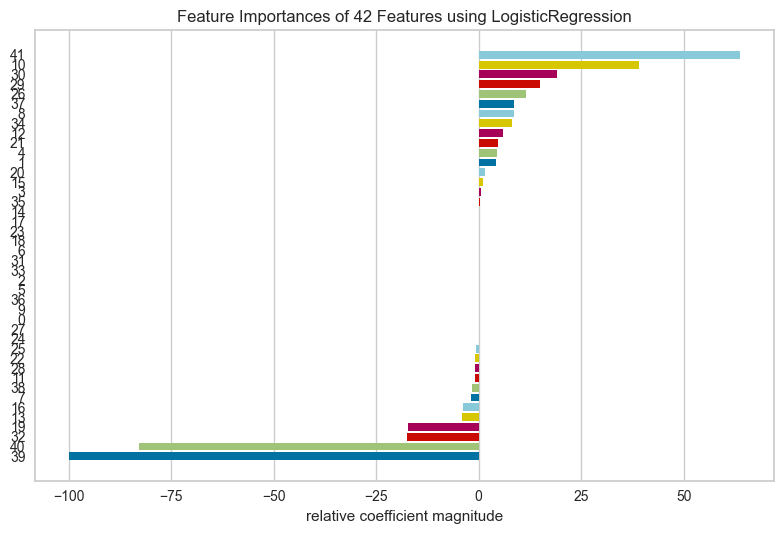

<Axes: title={'center': 'Feature Importances of 42 Features using LogisticRegression'}, xlabel='relative coefficient magnitude'>

In [21]:
# ajustar a visualização FeatureImportances no modelo logístico ajustado
viz = FeatureImportances(logistic_reg, feature_names=feature_names)
viz.fit(X_test_transformed, y_test)
viz.show()

## Calculate ROI
- Calculate LTV estimated in period
- Estimate LTV max
- Calculate possible impact from machine learning

### LTV

In [22]:
# Calculate LTV based cust monthly by customer * tenure (monthly before of churn)
df_copy['LTV'] = df_copy['MonthlyCharges'] * df_copy['tenure']

In [23]:
# Value of LTV in the company
print(f'Total LTV actual: R${round(sum(df_copy["LTV"]),2) }')

Total LTV actual: R$16055091.45


In [24]:
# Estimate Max LTV (38) is tenure average if customer not churner
df_copy['LTV Max'] = df_copy.apply(lambda x: x['MonthlyCharges'] * x['tenure'] if x['Churn'] == 'No' else 38 * x['MonthlyCharges'], axis=1)

In [25]:
# Value of LTV in the company
print(f'LTV Max if Churn == 0!: R${round(sum(df_copy["LTV Max"]),2) }')

LTV Max if Churn == 0!: R$18479486.85


In [26]:
# If machine learning model is a sucess the difference is next:
print(f'R${round(sum(df_copy["LTV Max"] - df_copy["LTV"]),2)} ')

R$2424395.4 


### ROI Machine Learning
- To account for both model accuracy and model recall in financial earnings calculations, we can use the confusion matrix to estimate the costs and benefits of each type of classification (true positives, false positives, false negatives, and true negatives). From these values, we can calculate the expected value of lost revenue due to customer evasion and the expected financial gain with a given confidence interval.
- O valor 1.96 é um número crítico usado para calcular o intervalo de confiança para uma média amostral com uma distribuição normal, com um nível de confiança de 95%. O intervalo de confiança é uma medida da incerteza na estimativa da média populacional a partir de uma amostra aleatória. Ele representa a faixa de valores em torno da estimativa da média amostral, dentro da qual é razoável afirmar que a média populacional real está contida com uma certa probabilidade.

In [27]:
def calcular_ganhos_financeiros(y_true:np.array, y_pred:np.array, custo_evasao:float, custo_aquisicao:float, custo_manutencao:float, numero_clientes_total:int)-> float:
    """
        calculate the expected value of lost revenue due to customer churn and the expected financial gain with a given confidence interval.

        Args:

            y_true (Series) - array of true classes in the data
            y_pred (Series) - array of predict classes from the model
            custo_evasao (float) - the financial cost to the company of losing a customer
            custo_aquisicao (float) - the financial cost for the company to acquire a new customer.
            custo_manutencao (float) - the financial cost for the company to retain a customer.
            numero_clientes_total (int) - the total number of customers in the company's database.

        Returns:
            ganho_esperado_min (float) - minimum impact financial
            ganho_esperado_max (float) - maximum impact financial
    """
    # Calcular a matriz de confusão do modelo
    matriz_confusao = cm(y_true, y_pred)

    # Calcular o número de clientes previstos pelo modelo para evadir e para ficar
    numero_clientes_evasao = matriz_confusao[1, :].sum()
    print(f'Número de clientes em evasão: {numero_clientes_evasao}')
    numero_clientes_ficar = matriz_confusao[0, :].sum()
    print(f'Número de clientes que ficaram: {numero_clientes_ficar}')

    # Calcular o custo e benefício esperado de cada tipo de classificação
    custo_fp = custo_aquisicao * matriz_confusao[0, 1] / numero_clientes_total
    print(f'Custo falso positivo: ${round(custo_fp,2)}')
    custo_fn = custo_evasao * matriz_confusao[1, 0] / numero_clientes_total
    print(f'Custo falso negativo: ${round(custo_fn,2)}')
    beneficio_tp = custo_manutencao * matriz_confusao[0, 0] / numero_clientes_total
    print(f'Beneficio verdadeiro positivo: ${round(beneficio_tp,2)}')
    beneficio_tn = 0
    print(f'Beneficio verdadeiro negativo: ${round(beneficio_tn,2)}')

    # Calcular o valor esperado da receita perdida devido à evasão de clientes
    valor_esperado = custo_fn * numero_clientes_evasao
    print(f'Valor esperado perdido por clientes em churn: ${round(valor_esperado,2)}')

    # Calcular o intervalo de confiança das predições do modelo
    recall = matriz_confusao[1, 1] / (matriz_confusao[1, 1] + matriz_confusao[1, 0])
    print(f'Recall: {round(recall,2)}')
    recall_std = np.sqrt(recall * (1 - recall) / numero_clientes_total)
    print(f'Desvio padrão Recall: {round(recall_std,2)}')
    intervalo_confianca = 1.96 * recall_std
    print(f'Intervalo de confiança: {round(intervalo_confianca,3)}')

    # Calcular o ganho financeiro esperado com 95% de confiança
    ganho_esperado_min = (beneficio_tp - custo_fp) * numero_clientes_ficar - intervalo_confianca * custo_fn * numero_clientes_evasao
    print(f'Ganho financeiro mínimo: ${round(ganho_esperado_min,2)}')
    ganho_esperado_max = (beneficio_tp - custo_fp) * numero_clientes_ficar + intervalo_confianca * custo_fn * numero_clientes_evasao
    print(f'Ganho financeiro máximo: ${round(ganho_esperado_max,2)}')

    return ganho_esperado_min, ganho_esperado_max


In [28]:
# the data of financial costs

# ( Possible LTV Max - LTV actual ) / Number of clientes churned in database
custo_evasao = round( sum(df_copy["LTV Max"] - df_copy["LTV"]) / df_copy[df_copy['Churn']=='Yes'].shape[0], 2)
# (CAC) estimated for Telco SA
custo_aquisicao = 500
# Estimated cust for mantain customer in the company
custo_manutencao = 200
# Number of total clientes in the database of Telco SA
numero_clientes_total = df_copy.shape[0]

# Calculate financial impacts know
min_, max_ = calcular_ganhos_financeiros(y_true=y_test, 
                                        y_pred=y_pred, 
                                        custo_evasao=custo_evasao,
                                        custo_aquisicao=custo_aquisicao,
                                        custo_manutencao=custo_manutencao,
                                        numero_clientes_total=numero_clientes_total)

Número de clientes em evasão: 197
Número de clientes que ficaram: 508
Custo falso positivo: $9.09
Custo falso negativo: $6.63
Beneficio verdadeiro positivo: $10.79
Beneficio verdadeiro negativo: $0
Valor esperado perdido por clientes em churn: $1306.18
Recall: 0.82
Desvio padrão Recall: 0.0
Intervalo de confiança: 0.009
Ganho financeiro mínimo: $853.75
Ganho financeiro máximo: $877.33


## Deploy

In [29]:
# with open(r'C:\Users\erico\Documents\projeto classificacao\Telco-Customer-Churn\models\model.pkl', 'wb') as f:
#     joblib.dump(model_pipe, f)

In [30]:
# with open(r'C:\Users\erico\Documents\projeto classificacao\Telco-Customer-Churn\models\model.pkl', 'rb') as f:
#     model = joblib.load(f)

In [31]:
model

LogisticRegression(C=10, class_weight='balanced', max_iter=300, penalty='l1',
                   random_state=42, solver='liblinear')

# Test API server

In [32]:
import json
import requests

In [33]:
test_api = X_test.sample(2)
test_api = test_api.reset_index()

url = 'http://127.0.0.1:5000/predict'
request_data = json.dumps(test_api.to_dict(orient='records'))
header = {'Content-type': 'application/json' } 
response = requests.post(url, request_data, headers=header)
print(f'Status Code: {response.status_code}')
print(response.text)

ConnectionError: HTTPConnectionPool(host='127.0.0.1', port=5000): Max retries exceeded with url: /predict (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x0000022CF917A5C0>: Failed to establish a new connection: [WinError 10061] Nenhuma conexão pôde ser feita porque a máquina de destino as recusou ativamente'))

In [ ]:
result_api = response.json()
df_result = pd.DataFrame(result_api)

In [ ]:
df_result

,customerID,SeniorCitizen,Partner,Dependents,tenure,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Prediction,Prescription
0,7353-YOWFP,No,No,No,7,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,20.25,129.15,0.20,No Potential Churn
1,0089-IIQKO,No,Yes,Yes,39,Yes,Fiber optic,No,No,No,Yes,Yes,Yes,Month-to-month,Yes,Credit card (automatic),99.95,3767.40,0.66,Moderate Potential Churn - Yellow alert
